# **[PlantVillage Disease Classification Challenge](https://www.crowdai.org/challenges/plantvillage-disease-classification-challenge)**

PlantVillage is built on the premise that all knowledge that helps people grow food should be openly accessible to anyone on the planet.

**Overview**

We depend on edible plants just as we depend on oxygen. Without crops, there is no food, and without food, there is no life. It's no accident that human civilization began to thrive with the invention of agriculture.

Today, modern technology allows us to grow crops in quantities necessary for a steady food supply for billions of people. But diseases remain a major threat to this supply, and a large fraction of crops are lost each year to diseases. The situation is particularly dire for the 500 million smallholder farmers around the globe, whose livelihoods depend on their crops doing well. In Africa alone, 80% of the agricultural output comes from smallholder farmers.

With billions of smartphones around the globe, wouldn't it be great if the smartphone could be turned into a disease diagnostics tool, recognizing diseases from images it captures with its camera? This challenge is the first of many steps turning this vision into a reality. PlantVillage is a not-for-profit project by Penn State University in the US and EPFL in Switzerland. We have collected - and continue to collect - tens of thousands of images of diseased and healthy crops. ***The goal of this challenge is to develop algorithms than can accurately diagnose a disease based on an image.***

Here are the 38 classes of crop disease pairs that the dataset is offering.  To learn more about the background of the dataset, please refer to the following paper: https://arxiv.org/abs/1511.08060v2. You must cite this paper if you use the dataset. 



**Evaluation**

Submissions will be evaluated using a Multi Class Log Loss evaluation function.

In [1]:
import os
import pandas as pd
import numpy as np
import random
import cv2
import pathlib
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from IPython.display import SVG
import IPython.display as display
import time as tm

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

import warnings
warnings.filterwarnings("ignore")

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions


import keras.backend as K
from keras.models import Sequential

from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input

import time as tm

Using TensorFlow backend.


Next will be show few images samples from the data set:

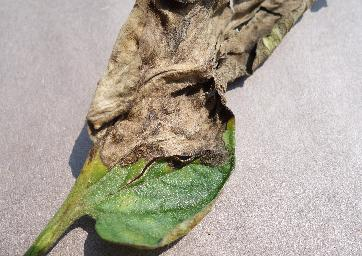

['c_30', '58a1fb7e-5af6-42f1-8694-c76fd80ebf05___RS_Late.B 7108.JPG']


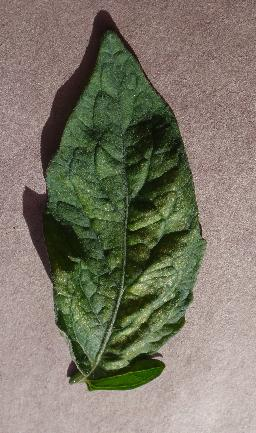

['c_33', '57e95bba-efa5-47e8-b069-a09fe0278146___Com.G_SpM_FL 8506.JPG']


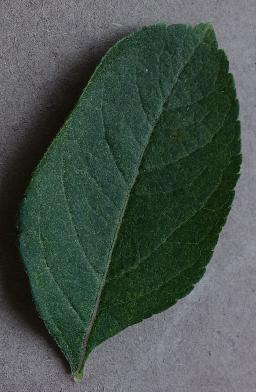

['c_3', '36c00bef-25c2-48ae-9505-41827bcd83d8___RS_HL 6085.JPG']


In [2]:
rootDir = 'crowdai'
data_root = pathlib.Path(rootDir)
all_image_paths = list(data_root.glob('*/*'))
for i in range(0,3):
    image_example = str(random.choice(all_image_paths))
    display.display(display.Image(image_example))
    print(image_example.split("/")[-2:])
# The first value correspond to folder name and it is its label, next values is the file name

The first value correspond image folder name and it's its label, and next value is the file name

# Load data and create labels

- Create function to read the files in root, and get a list with labels and image names.

After several attempts, and try different aproach, I  choose this way, because the way of dataframe was created keep the same read system order, because the classes or labels are in the same order that jupyter is reading the data, and the code is more clean than other approachs I did tested. I like this consistency, even though the data reading is more slow, but I'm keeping this approach for this work.

In [3]:
def make_labels(rootDir):
    '''
    From a given root, this function return a pandas dataframe with the classes and file names
    The data read is slow but it garanties the order in pandas, as pc read the files.
    inpu:
        rootDir: Root dir which contains the files by classes folder names
    return:
        d: Is an empty dataframe, wich is populated by files names and ist respective classes.
    '''
    df = pd.DataFrame()   
    idx = 0 
    for lists in os.listdir(rootDir): 
        path = os.path.join(rootDir, lists)
        aux_list = []
        for path, dirs, files in os.walk(path):
            key = path.split("/")[-1:][0]
            for file in files:
                temp = pd.DataFrame({'label': key, 'img':file},index=[idx])
                idx +=1
                df = pd.concat([df, temp])
    return df


The next are the function test, in order to get classes and files names from folders.

In [4]:
df = make_labels(rootDir)
df.head()

,label,img
0,c_1,f2b57a5b-f46d-453a-bb33-21d01d8a10de___JR_FrgE...
1,c_1,73b7ad12-02d0-4775-8f51-c7d404177132___JR_FrgE...
2,c_1,50afe8c7-d56e-4dd0-97b8-23a70ddca819___JR_FrgE...
3,c_1,1ce4ecdf-fe69-42df-a0dc-c90f5495e7a1___JR_FrgE...
4,c_1,464511a6-77d9-493f-bb3c-f151fb390f1b___JR_FrgE...


In [5]:
# Read file function

def get_im_cv2(path):
    img = cv2.imread(path)
    resized = cv2.resize(img, (64, 64), cv2.INTER_LINEAR)
    return resized

In [6]:
# file read checking
path = '../crowdai/c_1/f2b57a5b-f46d-453a-bb33-21d01d8a10de___JR_FrgE.S 3036.JPG'
a = cv2.imread(path)
a

In [7]:
# Data vectors load function
# source: https://www.kaggle.com/satian/keras-mobilenet-starter

def load_img(df):
    '''
    '''    
    m = df.shape[0]
    X = np.zeros((m, 64, 64, 3))
    count = 0
    for i in range(0,m):
        img = image.load_img(rootDir+"/"+df.ix[i][0]+"/"+df.ix[i][1], target_size=(64, 64, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        X[count] = x
        #if (count%1000 == 0):
        #    print("Processing image: ", count+1, ", ", fig)
        #count += 1
    label = list(df)[0]
    values = np.array(df[label])
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    y = onehot_encoded    
    
    return X, y, label_encoder
    


## Data augmentation

As experiment accuracy doesn't improve, this was 0.10 in average.  Maybe it must because data classes are imbalanced, as you can see in the next tables. In order to surpase this, I will try increasing the number of images repeating the numbers of images accord to proportion of the maximum images class.  First, I compute the number of times a class has with respect the maximum number image per class.  Then i will copy many times the class as it is in the maximun number of image in a class.

In [8]:
df_grouped = df.groupby(['label']).count().reset_index().copy().sort_values('img', ascending=False)
df_grouped

,label,img
7,c_15,2321
29,c_35,2100
17,c_24,1917
8,c_16,962
21,c_28,792
18,c_25,749
26,c_32,734
24,c_30,726
27,c_33,720
23,c_3,713


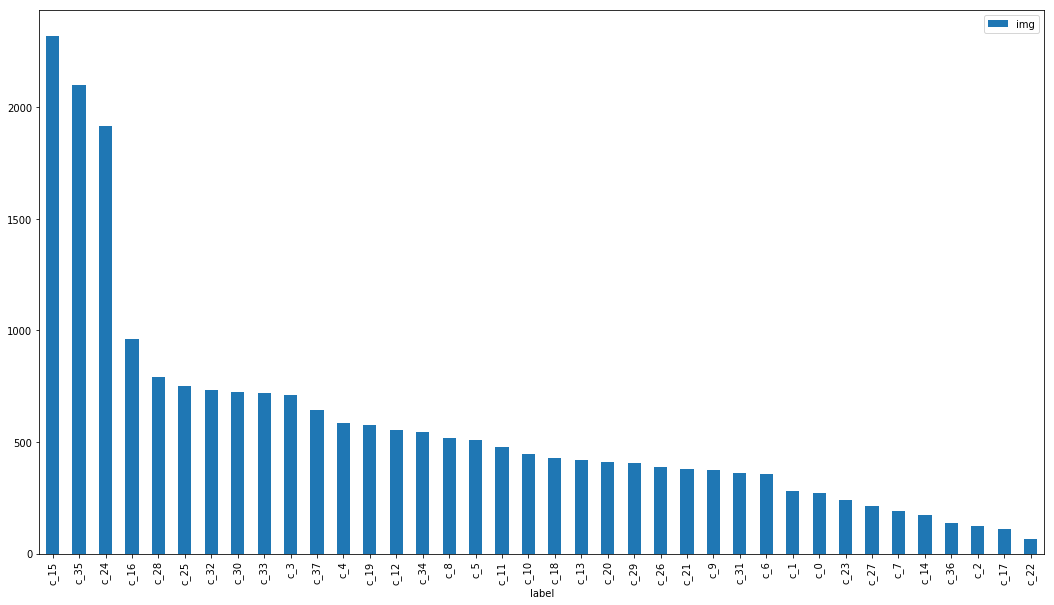

In [9]:
df_grouped.plot.bar(x ='label', figsize=(18,10))

In [10]:
df_grouped.describe()

,img
count,38.000000
mean,576.763158
std,505.201027
min,64.000000
25%,299.500000
50%,436.500000
75%,695.500000
max,2321.000000


The data is completely imbalanced, for that reason, must be find an approach to handle with this imbalances before the feed the Neural network. 

https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758

Oversampling with gans

https://github.com/JeffersonLPLima/adversarial_oversampling


https://medium.com/neuralspace/kaggle-1-winning-approach-for-image-classification-challenge-9c1188157a86


https://github.com/kumar-shridhar/CNN_Architectures/blob/master/Resnet50/resnet50.ipynb

In [11]:
df_grouped['Times'] = df_grouped['img'].max()//df_grouped['img']
df_grouped

,label,img,Times
7,c_15,2321,1
29,c_35,2100,1
17,c_24,1917,1
8,c_16,962,2
21,c_28,792,2
18,c_25,749,3
26,c_32,734,3
24,c_30,726,3
27,c_33,720,3
23,c_3,713,3


I make a copy of dataframe with file data information

In [12]:
df2 = df.copy()
df2[df.label == 'c_22']

,label,img
21276,c_22,b61b9d33-59ea-41b0-a554-c382eb6128c5___RS_HL 1...
21277,c_22,f0036dfd-9f46-4f2f-9001-5973495f2171___RS_HL 1...
21278,c_22,c9ad5c9a-c9b0-4e07-9e03-9e9edfd58a19___RS_HL 1...
21279,c_22,7948ada9-eabc-4cb7-a579-b73e938eb716___RS_HL 4...
21280,c_22,f30983c0-6e20-43cc-8672-4622ca34c830___RS_HL 1...
21281,c_22,1106c3fc-92cb-41a6-a6c6-8f08b9b45108___RS_HL 1...
21282,c_22,3edf7c3f-73e0-439c-870d-76cfd7c3bc45___RS_HL 1...
21283,c_22,bf2bffbb-cd8f-4d36-bd58-847808397c75___RS_HL 1...
21284,c_22,1b434c52-7be4-40c4-90d5-13220f1a3eba___RS_HL 5...
21285,c_22,2d98cbc8-cbe6-423c-b2ab-3f7f8bcea5d5___RS_HL 1...


In [13]:
df2.head()

,label,img
0,c_1,f2b57a5b-f46d-453a-bb33-21d01d8a10de___JR_FrgE...
1,c_1,73b7ad12-02d0-4775-8f51-c7d404177132___JR_FrgE...
2,c_1,50afe8c7-d56e-4dd0-97b8-23a70ddca819___JR_FrgE...
3,c_1,1ce4ecdf-fe69-42df-a0dc-c90f5495e7a1___JR_FrgE...
4,c_1,464511a6-77d9-493f-bb3c-f151fb390f1b___JR_FrgE...


In [14]:
for index,row in df_grouped.iterrows():
    df_aux = df[df.label == row['label']].copy()
    times_aux = row['Times']
    #print(df_aux.shape, times_aux)
    if  times_aux > 1:
        times_aux = times_aux - 1
        print(df_aux.shape,times_aux)
        df_n_aux = pd.concat([df_aux] * times_aux,ignore_index=True)
        print(df_n_aux.shape)
        df2 = df2.append(df_n_aux,ignore_index=True)
        #df_n = pd.concat([df2, df_n_aux],ignore_index=True) 
        print(df2.shape)

    
df2.shape
        #pd.concat([df]*3, ignore_index=True)

(962, 2) 1
(962, 2)
(22879, 2)
(792, 2) 1
(792, 2)
(23671, 2)
(749, 2) 2
(1498, 2)
(25169, 2)
(734, 2) 2
(1468, 2)
(26637, 2)
(726, 2) 2
(1452, 2)
(28089, 2)
(720, 2) 2
(1440, 2)
(29529, 2)
(713, 2) 2
(1426, 2)
(30955, 2)
(643, 2) 2
(1286, 2)
(32241, 2)
(586, 2) 2
(1172, 2)
(33413, 2)
(577, 2) 3
(1731, 2)
(35144, 2)
(552, 2) 3
(1656, 2)
(36800, 2)
(547, 2) 3
(1641, 2)
(38441, 2)
(519, 2) 3
(1557, 2)
(39998, 2)
(510, 2) 3
(1530, 2)
(41528, 2)
(476, 2) 3
(1428, 2)
(42956, 2)
(445, 2) 4
(1780, 2)
(44736, 2)
(428, 2) 4
(1712, 2)
(46448, 2)
(420, 2) 4
(1680, 2)
(48128, 2)
(412, 2) 4
(1648, 2)
(49776, 2)
(405, 2) 4
(1620, 2)
(51396, 2)
(390, 2) 4
(1560, 2)
(52956, 2)
(380, 2) 5
(1900, 2)
(54856, 2)
(374, 2) 5
(1870, 2)
(56726, 2)
(360, 2) 5
(1800, 2)
(58526, 2)
(358, 2) 5
(1790, 2)
(60316, 2)
(280, 2) 7
(1960, 2)
(62276, 2)
(270, 2) 7
(1890, 2)
(64166, 2)
(240, 2) 8
(1920, 2)
(66086, 2)
(214, 2) 9
(1926, 2)
(68012, 2)
(191, 2) 11
(2101, 2)
(70113, 2)
(171, 2) 12
(2052, 2)
(72165, 2)
(139, 2)

(80758, 2)

In [15]:
df2.shape

(80758, 2)

In [16]:
df_grouped2 = df2.groupby(['label']).count().reset_index().copy().sort_values('img', ascending=False)
df_grouped2

,label,img
7,c_15,2321
11,c_19,2308
15,c_22,2304
35,c_7,2292
14,c_21,2280
9,c_17,2268
18,c_25,2247
37,c_9,2244
1,c_1,2240
12,c_2,2232


In [17]:
df_grouped2.describe()

,img
count,38.000000
mean,2125.210526
std,159.316133
min,1584.000000
25%,2064.000000
50%,2160.000000
75%,2230.250000
max,2321.000000


In [18]:
X, y, label_encoder = load_img(df2)

In [19]:
_, NUM_CLASSES = y.shape
NUM_CLASSES

38

In [20]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=123)

In [21]:
# Image Standarization

data_generator = image.ImageDataGenerator(rotation_range=90,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    featurewise_center=True,
                                    featurewise_std_normalization=True,
                                    horizontal_flip=True)

data_generator.fit(X_train)

# standardize the test set
for i in range(len(X_test)):
    X_test[i] = data_generator.standardize(X_test[i])

## Neural Network Model

In [22]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [23]:
# Resnet50 model
base_model = ResNet50(input_shape=(64, 64, 3),include_top=False,weights= 'imagenet')

print(base_model.summary())

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
_____________________________________

In [24]:
# https://www.kaggle.com/amadeus1996/fruits-360-transfer-learning-using-keras

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
#x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(512, activation='relu')(x)
# and a fully connected output/classification layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
# create the full network so we can train on it
inception_transfer = Model(inputs=base_model.input, outputs=predictions)

In [25]:
inception_transfer.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=['acc'])

In [26]:
# https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
# https://keras.io/models/sequential/
batch_size=256
epochs = 100
ini = tm.time()

history =inception_transfer.fit_generator(
    generator=data_generator.flow(x=X_train,
                                  y=y_train,
                                  batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    shuffle = True, 
    verbose = 1,
    validation_data=(X_test, y_test))
end = tm.time()

elapsed = end - ini
print(elapsed/3600)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
283/283 [==============================] - 79s 277ms/step - loss: 3.6587 - acc: 0.0266 - val_loss: 3.6369 - val_acc: 0.0289
Epoch 2/100
283/283 [==============================] - 72s 255ms/step - loss: 3.6367 - acc: 0.0280 - val_loss: 3.6360 - val_acc: 0.0285
Epoch 3/100
283/283 [==============================] - 71s 250ms/step - loss: 3.6354 - acc: 0.0290 - val_loss: 3.6360 - val_acc: 0.0285
Epoch 4/100
283/283 [==============================] - 71s 250ms/step - loss: 3.6351 - acc: 0.0286 - val_loss: 3.6364 - val_acc: 0.0285
Epoch 5/100
283/283 [==============================] - 71s 250ms/step - loss: 3.6350 - acc: 0.0281 - val_loss: 3.6360 - val_acc: 0.0285
Epoch 6/100
283/283 [==============================] - 71s 251ms/step - loss: 3.6350 - acc: 0.0281 - val_loss: 3.6357 - val_acc: 0.0280
Epoch 7/100
283/283 [==============================] - 71s 250ms/step - loss: 3.6363 - acc: 0.0275 - val_loss: 3.6356 - val_acc: 0.0285


Epoch 59/100
283/283 [==============================] - 70s 247ms/step - loss: 3.6348 - acc: 0.0286 - val_loss: 3.6359 - val_acc: 0.0249
Epoch 60/100
283/283 [==============================] - 70s 247ms/step - loss: 3.6346 - acc: 0.0292 - val_loss: 3.6361 - val_acc: 0.0249
Epoch 61/100
283/283 [==============================] - 70s 247ms/step - loss: 3.6348 - acc: 0.0292 - val_loss: 3.6362 - val_acc: 0.0249
Epoch 62/100
283/283 [==============================] - 70s 247ms/step - loss: 3.6349 - acc: 0.0280 - val_loss: 3.6359 - val_acc: 0.0249
Epoch 63/100
283/283 [==============================] - 70s 247ms/step - loss: 3.6347 - acc: 0.0287 - val_loss: 3.6359 - val_acc: 0.0249
Epoch 64/100
283/283 [==============================] - 70s 247ms/step - loss: 3.6346 - acc: 0.0289 - val_loss: 3.6359 - val_acc: 0.0249
Epoch 65/100
283/283 [==============================] - 70s 247ms/step - loss: 3.6351 - acc: 0.0285 - val_loss: 3.6360 - val_acc: 0.0285
Epoch 66/100
283/283 [===================

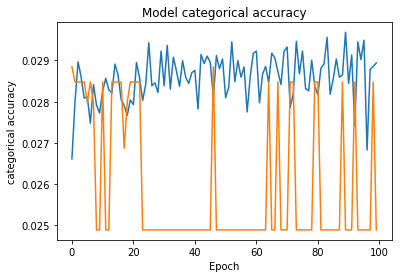

In [27]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model categorical accuracy')
plt.ylabel('categorical accuracy')
plt.xlabel('Epoch')
plt.show()